# 2+ Clustering with Max-cut
This notebook is an example of unsupervised learning on a quantum computer. The data used are from the iris data set.

In the previous notebook [Max-cut.ipynb](https://github.com/ajrazander/Unsupervised-QML/blob/master/Max-cut.ipynb), the max-cut problem was solved using QAOA, which theoretically gives a quantum speed up to unsupervised learning. Solving the max-cut problem is a binary classifier. What if the data are more naturally separated into more than two groups though?


## Divisive Hierarchical Quantum Clustering
One solution is to apply a divisive ("top-down") [hierarchial clustering](https://en.wikipedia.org/wiki/Hierarchical_clustering) scheme. This scheme starts with the whole data set (the top). Using a binary classifier (like QAOA solving max-cut), the data is split into two child clusters. breaks up all data points are individual clusters (the bottom). For QAOA solving max-cut a divisive hierarchical clustering algorithm would execute as follows: (0) solve the max-cut problem on the entire dataset resulting in two child clusters, (1) solve the max-cut problem on each child cluster, repeat (1) until every data point is in an individual cluster. But, what if our intuition tells us the best clustering for a dataset is before the every-data-point-is-its-own-cluster level? Answer: introduce a stop criteria--more on this later.

Let's get to it!

In [2]:
import numpy as np
import pandas as pd
from numba import jit
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
import seaborn as sns

# Load IBM quantum computing options
from qiskit import IBMQ
IBMQ.load_account()  # Load account from disk

# Quantum Computing packages
from qiskit import BasicAer
from qiskit.aqua import QuantumInstance
from qiskit.aqua.algorithms import QAOA
from qiskit.aqua.translators.ising import max_cut
from qiskit.aqua.components.optimizers import COBYLA

In [3]:
# Import Iris dataset
iris_data = load_iris()
df = pd.DataFrame(iris_data.data, columns=iris_data.feature_names)
df['species'] = pd.Categorical.from_codes(iris_data.target, iris_data.target_names)
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


The iris dataset contains 150 data points. For reasonable execution time on the simulated quantum computer, we'll need to chop this down to ~12 points.

In [4]:
# Remove species labels
data_full = df.loc[:, ['petal length (cm)', 'petal width (cm)', 'sepal length (cm)', 'sepal width (cm)']]

# Reduce number of data points
df_sub = df[::13]  # Dataframe with species labels
data_sub = data_full[::13]  # Dataframe without species lables
print(len(data_sub), 'data points')

12 data points


Now that the data is all squared away, let's solve the max-cut problem with QAOA just as we did in the [previous notebook](https://github.com/ajrazander/Unsupervised-QML/blob/master/Max-cut.ipynb) except this time we want to solve the max-cut problem on each resulting child cluster. To do this, we will track how the data is cut each iteration and recursively solve the max-cut problem on each resulting child cluster. Please forgive the messy of for loops and if statements needed to track the child clusters.

Each division of the dataset into child clusters can be thought of as generating new leaf nodes on a binary tree. The root node is the whole dataset. The root node's two child nodes each contain half of the dataset. Their child nodes contain one quarter of the dataset and so on. Since the end case in the divisive hierarchical scheme has all $n$ data points in their own clusters, there must be $n$ leaf nodes. For a well balanced binary tree, that leaves (no pun intended) the height $h=\log_2{\left(n+1\right)}$. For our situation this means at least $h$ iterations need to be completed.

Let's put these pieces together. First we'll need to define a function that computes the $l^2\text{-norm}$ as done in the previous notebook.

In [5]:
# Helper function for next block

# Computes pairwise L2-norms (@jit gives x10 speed up)
@jit(nopython=True)
def calc_w(data_array):
    n_instances = data_array.shape[0]
    w = np.zeros((n_instances, n_instances))
    for i in range(0,n_instances):
        for j in range(0,n_instances):
            w[i, j] = np.linalg.norm(data_array[i]-data_array[j])
    return w

Next, we do the heavy lifting. The max-cut problem is solved recursively over the child clusters a total of $h$ times.

In [6]:
# This can take several minutes to run

# Minimum iterations to turn data points into their own clusters (i.e. height of perfect binary tree)
h = int(np.log2(len(data_sub)+1))

# Max number of qubits your computer can simulate. Needs to be >= than the number of data points in data_sub.
comp_qubits = 15

# Copy data for future manipulations
data = data_sub.copy()

# QAOA hyperparameters and backend initialization
p = 1  # Number of adiabatic steps must be > 0
optimizer = COBYLA()  # Arbitrary selection
#provider = IBMQ.get_provider(group='open')  # Load provider to access IBM's cloud services
#backend_ibm = provider.get_backend('ibmq_qasm_simulator')  # Simulate on IBM's cloud services
backend_local = BasicAer.get_backend('statevector_simulator')  # Simulate on local machine

# Iterate over height of data set tree
for i in range(0, h):
    # Initialize 'labels' column for future QAOA output
    data.loc[:, 'cluster_'+str(i)] = np.nan
    data.loc[:, 'cut_'+str(i)] = np.nan
    
    # Select data from the previous child clusters
    dfs = []
    if i > 0:
        cluster_range = data.loc[:, 'cluster_'+str(i-1)].unique()
        for j in cluster_range:
            df_cluster = data.loc[data['cluster_'+str(i-1)] == j, data.columns[:4]]
            # if df_cluster length is 1 then it can't be further cut, so only consider lengths > 1
            if len(df_cluster.index) > 1:
                dfs.append(df_cluster)
    else:
        dfs.append(data[data.columns[:4]])

    # Solve max-cut with QAOA on each child cluster
    for j, df_part in enumerate(dfs):
        w = calc_w(df_part.values)  # Calculate pairwise distances between points
        
        # Initialize QAOA and execute
        qubit_ops, offset = max_cut.get_max_cut_qubitops(w)
        qaoa = QAOA(qubit_ops, optimizer, p)
        # If there are 'too many' qubits, use IBM's 32 qubit backend
        if w.shape[0] > comp_qubits:
            backend = backend_ibm
        else:
            backend = backend_local
        quantum_instance = QuantumInstance(backend, shots=1, skip_qobj_validation=False)
        result = qaoa.run(quantum_instance)

        # Extract results
        x = max_cut.sample_most_likely(result['eigvecs'][0])

        # Store cluster results back into Dataframe. Labels must be unqiue each iteration hence + 2*j
        df_part.loc[:, 'cluster_'+str(i)] = max_cut.get_graph_solution(x) + 2*j
        df_part.loc[:, 'cut_'+str(i)] = max_cut.max_cut_value(x, w)
        
        # Update Dataframe with new clusters and cut weights
        data.update(df_part)

    print('Iteration', i+1, 'of', h, 'completed')

/Users/Razander/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/Razander/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:562: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


Iteration 1 of 3 completed
Iteration 2 of 3 completed
Iteration 3 of 3 completed


Let's take a look at how the clustering compares to the known species labeling.

In [7]:
# Include results from QAOA in df_sub dataframe for comparison to species label
for i in range(0, h):
    df_sub.loc[:, 'cluster_'+str(i)] = data.loc[:, 'cluster_'+str(i)]
    df_sub.loc[:, 'cut_'+str(i)] = data.loc[:, 'cut_'+str(i)]
df_sub

/Users/Razander/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:480: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species,cluster_0,cut_0,cluster_1,cut_1,cluster_2,cut_2
0,5.1,3.5,1.4,0.2,setosa,0.0,150.460827,0.0,2.974861,0.0,0.561177
13,4.3,3.0,1.1,0.1,setosa,0.0,150.460827,1.0,2.974861,NaN,NaN
26,5.0,3.4,1.6,0.4,setosa,0.0,150.460827,0.0,2.974861,1.0,0.561177
39,5.1,3.4,1.5,0.2,setosa,0.0,150.460827,0.0,2.974861,0.0,0.561177
52,6.9,3.1,4.9,1.5,versicolor,1.0,150.460827,3.0,30.857643,3.0,3.252945
65,6.7,3.1,4.4,1.4,versicolor,1.0,150.460827,3.0,30.857643,3.0,3.252945
78,6.0,2.9,4.5,1.5,versicolor,1.0,150.460827,3.0,30.857643,2.0,3.252945
91,6.1,3.0,4.6,1.4,versicolor,1.0,150.460827,3.0,30.857643,2.0,3.252945
104,6.5,3.0,5.8,2.2,virginica,1.0,150.460827,2.0,30.857643,5.0,4.912491
117,7.7,3.8,6.7,2.2,virginica,1.0,150.460827,2.0,30.857643,4.0,4.912491


Under the "cluster_2" column, we see the clustering is not at all similar to the species labeling. This is because each data point is nearly in its own cluster. Let's assume we don't already know how the data should cluster, but we do have an educated guess that there is some "best" number of clusters less than 10. How do we stop the clustering process at this "best" number of clusters instead of clustering the entire dataset into individual clusters? To resolve this, we can set a cutoff. What cutoff do we choose? Let's first take a lesson from k-means.

## Stop Criteria: elbow rule
To find the best clustering, we first follow the elbow rule just like in k-means.

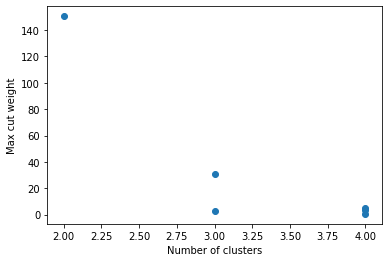

In [8]:
# Plot max-cut weights vs number of clusters created
cluster_num = []  # initialize x-axis array
cuts = []  # initialize y-axis array

# Extract max-cut weights and associated number of clusters from results in df_sub
for i in range(0, h):
    # Collect max-cut weights
    cuts += list(df_sub['cut_'+str(i)].unique())
    # Number how many clusters have been made for this cut
    cut_off = 2**i
    for j in range(0, cut_off):
        cluster_num.append(i+2)

plt.scatter(cluster_num, cuts)
plt.xlabel('Number of clusters')
plt.ylabel('Max cut weight')
plt.show()

We see from the plot, the elbow is at 3 clusters. However, which of the two possible 3 cluster configurations do we choose? Answer: the one with the higher cut weight. The higher cut weight indicates a more separated graph--exactly what we want.

## Stop Criteria as a depth-first-search

The task of finding the stopping point is best recast as a depth-first-search where the tree being searched is made from all the computed cut weights. Starting at the root node of 150.5, we traverse down the tree to leaves with the highest cut weights. Along the way we "keep" those cuts we've encountered until there are as many clusters as the elbow rule advises.

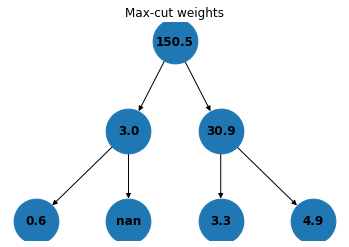

In [9]:
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout

# Initialize graph
G = nx.DiGraph()

# Set root node as weight of the very first cut; in this case 150.46.
G.add_node("{:.1f}".format(cuts[0]))

# Add the remaining cut weights to the tree
for cut in cuts[1:]:
    if np.isnan(cut):  # ignore nan cut weights
        continue
    G.add_node("{:.1f}".format(cut))

# Add edges from parent to child clusters
for i in range(int(np.log2(len(cuts)+1))):
    G.add_edge("{:.1f}".format(cuts[i]), "{:.1f}".format(cuts[2*i+1]))
    G.add_edge("{:.1f}".format(cuts[i]), "{:.1f}".format(cuts[2*i+2]))

# Plot graph

# write dot file to use with graphviz
# run "dot -Tpng test.dot >test.png"
nx.nx_agraph.write_dot(G, 'test.dot')

# same layout using matplotlib with no labels
plt.title('Max-cut weights')
pos = graphviz_layout(G, prog='dot')
nx.draw(G, pos, with_labels=True, font_weight='bold', node_size=2000)
plt.show()

Following the stop criteria rules, we transverse the tree starting at the root node 150.5. Since $30.9 > 3.0$, we move to 30.9 and keep that cut. At this point, the two cuts 150.5 and 30.9 generate 3 clusters labeled 0.0, 2.0, and 3.0. Since the elbow rule tells us to stop at 3 clusters, we stop here. Let's see how the stop criteria does by comparing these 3 clusters to the original species labeling.

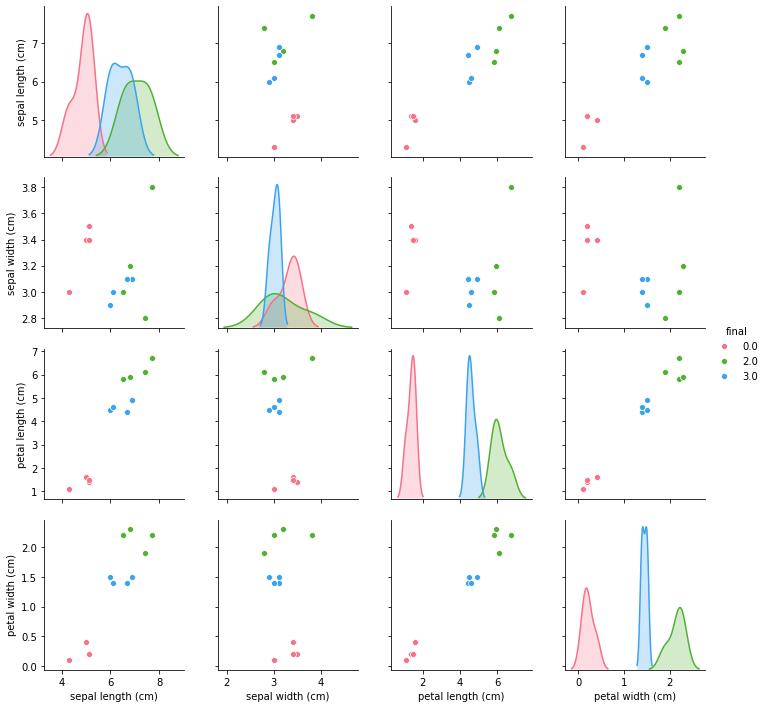

"Average" label classification:
species
setosa        0.0
versicolor    3.0
virginica     2.0
Name: final, dtype: float64


In [11]:
# maximum number of clusters as given by the elbow rule
max_clusters = 3

# Initialize final clustering column
df_sub.loc[:, 'final'] = np.nan

for (cluster, cut_weight) in zip(df_sub[df_sub.columns[5::2]],df_sub[df_sub.columns[6::2]]):
    # Find the maximum cut for this particular column of data
    maxim = df_sub[cut_weight].max()
    df_sub['final'].update(df_sub[cluster][df_sub[cut_weight] == maxim])
    if len(df_sub['final'].unique()) >= max_clusters:  # stop including clusters once the number of clusters reaches the elbow rule limit
        break

# Constrain data to final clustering assignments
df_sub_plot = df_sub[['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)', 'final']]

# Visualize clustering
sns.pairplot(data=df_sub_plot, hue='final', palette="husl", vars=df_sub.columns[:4])
plt.show()

# Display mean of cluster labels by species
print('\"Average\" label classification:')
print(df_sub.groupby(['species']).sum()['final'] / df_sub.groupby(['species']).count()['final'])

The 'Average' label classification is an average over the cluster label (0, 2, or 3) for each species. Setosa is all in cluster 0; versicolor is all in cluster 2; and virginica is all in cluster 3. The divisive hierarchical quantum clustering did a great job!